In [1]:
from tqdm import tqdm 
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import medmnist 
from medmnist import INFO, Evaluator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import roc_auc_score

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MEDMNIST v2.1.0 @ https://github.com/MedMNIST/MedMNIST/
The number of classes is: 2 
 The number of channels is 1.
The class_names are {'0': 'normal', '1': 'pneumonia'}
{'python_class': 'PneumoniaMNIST', 'description': 'The PneumoniaMNIST is based on a prior dataset of 5,856 pediatric chest X-Ray images. The task is binary-class classification of pneumonia against normal. We split the source training set with a ratio of 9:1 into training and validation set and use its source validation set as the test set. The source images are gray-scale, and their sizes are (384−2,916)×(127−2,713). We center-crop the images and resize them into 1×28×28.', 'url': 'https://zenodo.org/record/6496656/files/pneumoniamnist.npz?download=1', 'MD5': '28209eda62fecd6e6a2d98b1501bb15f', 'task': 'binary-class', 'label': {'0': 'normal', '1': 'pneumonia'}, 'n_channels': 1, 'n_samples': {'train': 4708, 'val': 524, 'test': 624}, 'license': 'CC BY 4.0'}
Using downloaded and verified file: C:\Users\Theodora\.medmnist\

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


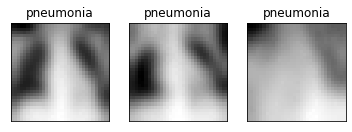

In [2]:
from dataset import train_dataset, test_dataset, n_classes, n_channels, class_names, test_loader, task

In [3]:
def save_test_results(tensor, labels, output_class, counter):
    '''
    This function will save a few test images along with the
    ground truth label and predicted label annotated on the image
    
    :param tensor: the image tensor
    :param target: the ground truth class
    param output_class: the predicted class number
    param counter: the test image number
    '''
    
    # Move tensor to cpu and denormalize
    image = torch.squeeze(tensor, 0).cpu().numpy()
    image = image/2 + 0.5
    image = np.transpose(image, (1,2,0))
    # Convert to RGB format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    gt = labels.cpu().numpy()
    cv2.putText(
    image, f"GT: {gt}",
    (5,25), cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(
    image, f"Pred: {output_class}",
    (5, 55), cv2.FONT_HERSHEY_SIMPLEX, 
    0.7, (0,255,0), 2, cv2.LINE_AA)
    
    cv2.imwrite(f"../outputs/test_image_{counter}.png", image*255.)
    

In [4]:
def test(model, testloader, task):
    model.eval()
    print('Testing the model')
    prediction_list = []
    ground_truth_list = []
    test_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total = len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = model(image)
            if task == 'multi-label, binary-class':
                predictions = torch.sigmoid(outputs, 1).cpu().numpy()
            else:
                predictions = F.softmax(outputs, 1).cpu().numpy()
            output_class = np.argmax(predictions)

            # Append the GT and predictions to the respective lists
            prediction_list.append(output_class)
            ground_truth_list.append(labels.cpu().detach().numpy().flatten())
            # Calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            test_running_correct += (preds == labels.squeeze().long()).sum().item()
            # Save few test images
            if counter % 99 == 0:
                save_test_results(image, labels, output_class, counter)
        acc = 100.*(test_running_correct/ len(testloader.dataset))
        return prediction_list, ground_truth_list, acc
                

In [ ]:
if __name__ == '__main__':
    
    model = LeNet(n_channels, n_classes)  # LeNet accyracy: 89.075
    print(model.__class__.__name__ )
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.load_state_dict(torch.load('../outputs/mnist_pneumonia_lenet.ckpt', map_location=torch.device('cpu')))
    
    prediction_list, ground_truth_list, acc = test(model, test_loader, task)
    print(f"Test accuracy: {acc:.3f}%")
    
   
    
    # Confusion matrix
    conf_matrix = confusion_matrix(ground_truth_list, prediction_list)
    
    plt.figure(figsize=(12,9))

    sns.heatmap(
    conf_matrix, 
    annot = True,
    xticklabels = class_names,
    yticklabels = class_names)
    
    plt.savefig('../outputs/heatmaps_ConvNet_Pneumonia.png')
    plt.close()


LeNet


In [5]:
import argparse

def test_options():
    parser = argparse.ArgumentParser()
    parser.add_argument('model', model = 'LeNet')
    parser.add_argument('model.load_state_dict', model.load_state_dict(torch.load('../mnist_pneumonia_lenet')))

In [6]:
#model = LeNet(_channnels, n_classes)
print(model.__class__.__name__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)
prediction_list, ground_truth_list, acc = test(model, test_loader, task)
print(f'Test accuracy: {acc:.3f}%')

NameError: name 'model' is not defined